In [31]:
%load_ext autoreload
%autoreload 2
from rekall import Interval, IntervalSet, IntervalSetMapping, Bounds3D
from rekall.predicates import *
from matplotlib import pyplot as plt
import time
import json
import csv
import pandas as pd
import numpy as np
from collections import defaultdict

In [33]:
from cyclist_tutorial_helpers import *

In [34]:
class DataSource:
    def __init__(self, filename):
        self.filename=filename # path to data file
        self.data = []
        self.data_map = None
        with open(filename, 'r') as f:
            csv_reader = csv.reader(f, delimiter=',')
            line_count = 0
            for row in csv_reader:
                if line_count == 0:
                    header = row
                    print(f'Column header: {", ".join(header)}')
                    # Column should be frame_id, person_score, dog_score, person_label, dog_label
                else:
                    person = {"score": float(row[1]), "class": row[4]=="True", "box": [0.,1.,0.,1.]}
                    dog = {"score": float(row[2]), "class": row[5]=="True", "box": [0.,1.,0.,1.]}
                    self.data.append({
                        'frame_id': float(row[0]),
                        'person': person,
                        'dog': dog })
                line_count += 1
        self.data_size = len(self.data)
        self.build()
    
    def aggregate_interval(intrvl_set, pred, merge_op):
        new_set = []
        size = len(intrvl_set)
        new_set.append(intrvl_set[0])
        for i in range(1, size):
            if pred(intrvl_set[i], new_set[-1]):
                new_set[-1] = merge_op(intrvl_set[i], new_set[-1])
            else:
                new_set.append(intrvl_set[i])
        print(f'After aggregation: len {size} --> {len(new_set)}')
        return new_set

    def build(self):
        persons = []
        dogs = []
        for frame in self.data:
            person_bound = Bounds3D(
                t1 = (frame['frame_id'])/30.0,
                t2 = (frame['frame_id']+1)/30.0, 
                x1 = frame['person']['box'][0], 
                x2 = frame['person']['box'][1], 
                y1 = frame['person']['box'][2], 
                y2 = frame['person']['box'][3]
            )
            person_payload = {"score": frame['person']['score'], "class": frame['person']['class']}
            person_interval = Interval(person_bound, payload = person_payload)
            persons.append(person_interval)
            
            dog_bound = Bounds3D(
                t1 = (frame['frame_id'])/30.0,
                t2 = (frame['frame_id']+1)/30.0, 
                x1 = frame['dog']['box'][0], 
                x2 = frame['dog']['box'][1], 
                y1 = frame['dog']['box'][2], 
                y2 = frame['dog']['box'][3]
            )
            dog_payload = {"score": frame['dog']['score'], "class": frame['dog']['class']}
            dog_interval = Interval(dog_bound, payload = dog_payload)
            dogs.append(dog_interval)
    
        self.data_map = {
            'person': IntervalSetMapping({0: IntervalSet(persons)}),
            'dog': IntervalSetMapping({0: IntervalSet(dogs)})
        }
    
    def getall(self):
        return self.data_map
    
    def get(self, key):
        return self.getall()[key]

In [35]:
class TextSource:
    def __init__(self, filename):
        self.filename=filename # path to data file
        self.data = []
        self.data_map = None
        with open(filename, 'rb') as f:
            self.data = pickle.load(f)
        self.data_size = len(self.data)
        self.build()
    
    def aggregate_interval(intrvl_set, pred, merge_op):
        new_set = []
        size = len(intrvl_set)
        new_set.append(intrvl_set[0])
        for i in range(1, size):
            if pred(intrvl_set[i], new_set[-1]):
                new_set[-1] = merge_op(intrvl_set[i], new_set[-1])
            else:
                new_set.append(intrvl_set[i])
        print(f'After aggregation: len {size} --> {len(new_set)}')
        return new_set

    def build(self):
        trans = []
        for frames in self.data:
            trans_bound = Bounds3D(
                t1 = frames['start_ts'],
                t2 = frames['end_ts'], 
                x1 = 0., 
                x2 = 1., 
                y1 = 0., 
                y2 = 1.
            )
            trans_payload = {"class": frames['word'], "score": 1.}
            trans_interval = Interval(trans_bound, payload = trans_payload)
            trans.append(trans_interval)
    
        self.data_map = {
            'transcript': IntervalSetMapping({0: IntervalSet(trans)})
        }
    
    def getall(self):
        return self.data_map
    
    def get(self, key):
        return self.getall()[key]

In [36]:
frame_ds = DataSource("/Users/cchaokun/repos/MMVP/data/result.csv")
text_ds = trans = TextSource("/Users/cchaokun/repos/MMVP/data/text.pkl")

Column header: id, proxy_0_score, proxy_1_score, proxy_score, label_0, label_1, label


In [37]:
humans = frame_ds.get("person")
cars= frame_ds.get("dog")
trans = text_ds.get("transcript")

In [38]:
print(len(humans[0]), humans[0].get_intervals()[:10])
print(len(cars[0]), cars[0].get_intervals()[:10])
print(len(trans[0]), trans[0].get_intervals()[:10])

humans[0].get_intervals()[:10]

705692 [<Interval t1:0.0 t2:0.03333333333333333 x1:0.0 x2:1.0 y1:0.0 y2:1.0 payload:{'score': 0.22097363, 'class': False}>, <Interval t1:0.03333333333333333 t2:0.06666666666666667 x1:0.0 x2:1.0 y1:0.0 y2:1.0 payload:{'score': 0.22426856, 'class': False}>, <Interval t1:0.06666666666666667 t2:0.1 x1:0.0 x2:1.0 y1:0.0 y2:1.0 payload:{'score': 0.22147104, 'class': False}>, <Interval t1:0.1 t2:0.13333333333333333 x1:0.0 x2:1.0 y1:0.0 y2:1.0 payload:{'score': 0.22145826, 'class': False}>, <Interval t1:0.13333333333333333 t2:0.16666666666666666 x1:0.0 x2:1.0 y1:0.0 y2:1.0 payload:{'score': 0.21736403, 'class': False}>, <Interval t1:0.16666666666666666 t2:0.2 x1:0.0 x2:1.0 y1:0.0 y2:1.0 payload:{'score': 0.21997072, 'class': False}>, <Interval t1:0.2 t2:0.23333333333333334 x1:0.0 x2:1.0 y1:0.0 y2:1.0 payload:{'score': 0.22122926, 'class': False}>, <Interval t1:0.23333333333333334 t2:0.26666666666666666 x1:0.0 x2:1.0 y1:0.0 y2:1.0 payload:{'score': 0.22157837, 'class': False}>, <Interval t1:0.2

[<Interval t1:0.0 t2:0.03333333333333333 x1:0.0 x2:1.0 y1:0.0 y2:1.0 payload:{'score': 0.22097363, 'class': False}>,
 <Interval t1:0.03333333333333333 t2:0.06666666666666667 x1:0.0 x2:1.0 y1:0.0 y2:1.0 payload:{'score': 0.22426856, 'class': False}>,
 <Interval t1:0.06666666666666667 t2:0.1 x1:0.0 x2:1.0 y1:0.0 y2:1.0 payload:{'score': 0.22147104, 'class': False}>,
 <Interval t1:0.1 t2:0.13333333333333333 x1:0.0 x2:1.0 y1:0.0 y2:1.0 payload:{'score': 0.22145826, 'class': False}>,
 <Interval t1:0.13333333333333333 t2:0.16666666666666666 x1:0.0 x2:1.0 y1:0.0 y2:1.0 payload:{'score': 0.21736403, 'class': False}>,
 <Interval t1:0.16666666666666666 t2:0.2 x1:0.0 x2:1.0 y1:0.0 y2:1.0 payload:{'score': 0.21997072, 'class': False}>,
 <Interval t1:0.2 t2:0.23333333333333334 x1:0.0 x2:1.0 y1:0.0 y2:1.0 payload:{'score': 0.22122926, 'class': False}>,
 <Interval t1:0.23333333333333334 t2:0.26666666666666666 x1:0.0 x2:1.0 y1:0.0 y2:1.0 payload:{'score': 0.22157837, 'class': False}>,
 <Interval t1:0.

In [39]:
""" We have three type of object without bounding boxes.
IntervalSets:
humans: the frames that containing (at least one) human. 
cars  : the frames that containing (at least one) car. 
trans : the frames that containing (at least one) voices (we transfer it to text). 

Limitation:
currently we don't have tracking, thus we don't know who is in each frame, and who is talking.
currently we do not have boudning boxes, we consider each object in frame locates on the full frame.
"""

humans = humans.filter(lambda interval: interval['payload']['class'] == True) # each frame is an row
cars= cars.filter(lambda interval: interval['payload']['class'] == True) # each frame is an row
trans = trans # multiple frames in an row, single word per row

In [40]:
print(len(humans[0]), humans[0].get_intervals()[:10])
print(len(cars[0]), cars[0].get_intervals()[:10])
print(len(trans[0]), trans[0].get_intervals()[:10])

657523 [<Interval t1:12.533333333333333 t2:12.566666666666666 x1:0.0 x2:1.0 y1:0.0 y2:1.0 payload:{'score': 0.2964853, 'class': True}>, <Interval t1:12.566666666666666 t2:12.6 x1:0.0 x2:1.0 y1:0.0 y2:1.0 payload:{'score': 0.365947, 'class': True}>, <Interval t1:12.6 t2:12.633333333333333 x1:0.0 x2:1.0 y1:0.0 y2:1.0 payload:{'score': 0.41067186, 'class': True}>, <Interval t1:12.633333333333333 t2:12.666666666666666 x1:0.0 x2:1.0 y1:0.0 y2:1.0 payload:{'score': 0.46960527, 'class': True}>, <Interval t1:12.666666666666666 t2:12.7 x1:0.0 x2:1.0 y1:0.0 y2:1.0 payload:{'score': 0.5214382, 'class': True}>, <Interval t1:12.7 t2:12.733333333333333 x1:0.0 x2:1.0 y1:0.0 y2:1.0 payload:{'score': 0.566438, 'class': True}>, <Interval t1:12.733333333333333 t2:12.766666666666667 x1:0.0 x2:1.0 y1:0.0 y2:1.0 payload:{'score': 0.59745246, 'class': True}>, <Interval t1:12.766666666666667 t2:12.8 x1:0.0 x2:1.0 y1:0.0 y2:1.0 payload:{'score': 0.599778, 'class': True}>, <Interval t1:12.8 t2:12.83333333333333

In [41]:
def merge_score(payload1, payload2):
    # Score is currenlt not used for query, but in fact we should use it. 
    return max(payload1['score'], payload2['score'])

def merge_words(payload1, payload2):
    return payload1['class'] + " " + payload2['class']

t = time.time()
cars= cars.coalesce(
    ('t1', 't2'),
    bounds_merge_op=Bounds3D.span,
    payload_merge_op=lambda payload1, payload2: {"score": merge_score(payload1, payload2), "class":payload1['class']},
    predicate=lambda intrvl1, intrvl2: intrvl1['payload']['class'] == intrvl2['payload']['class'],
    epsilon=0.1
)
t = time.time() - t
print("Time cost: ", t)

t = time.time()
humans= humans.coalesce(
    ('t1', 't2'),
    bounds_merge_op=Bounds3D.span,
    payload_merge_op=lambda payload1, payload2: {"score": merge_score(payload1, payload2), "class":payload1['class']},
    predicate=lambda intrvl1, intrvl2: intrvl1['payload']['class'] == intrvl2['payload']['class'],
    epsilon=0.1
)
t = time.time() - t
print("Time cost: ", t)

t = time.time()
trans= trans.coalesce(
    ('t1', 't2'),
    bounds_merge_op=Bounds3D.span,
    payload_merge_op=lambda payload1, payload2: {"score": merge_score(payload1, payload2), "class":merge_words(payload1, payload2)},
    predicate=true_pred(),
    epsilon=1.0
)
t = time.time() - t
print("Time cost: ", t)

Time cost:  10.35112714767456
Time cost:  18.106746196746826
Time cost:  6.15621280670166


In [46]:
t = time.time()
trans = text_ds.get("transcript")
trans= trans.coalesce(
    ('t1', 't2'),
    bounds_merge_op=Bounds3D.span,
    payload_merge_op=lambda payload1, payload2: {"score": merge_score(payload1, payload2), "class":merge_words(payload1, payload2)},
    predicate=true_pred(),
    epsilon=1.0
)
t = time.time() - t
print("Time cost: ", t)
print(len(trans[0]))
trans[0].get_intervals()[:10]

Time cost:  1.820924997329712
840


[<Interval t1:0.68 t2:1.08 x1:0.0 x2:1.0 y1:0.0 y2:1.0 payload:{'class': 'forward', 'score': 1.0}>,
 <Interval t1:15.88 t2:20.2 x1:0.0 x2:1.0 y1:0.0 y2:1.0 payload:{'score': 1.0, 'class': 'it was voted tra year but that did not stop getting the x'}>,
 <Interval t1:24.04 t2:102.11 x1:0.0 x2:1.0 y1:0.0 y2:1.0 payload:{'score': 1.0, 'class': "the one hundred and fifty year old trree taken down the gu k to make way for a ousing development that apparently did not include the t in its plan strangely symbolic moment for a country that's been notcked down and now lot down again showed out in georgia voters taken to the polls today waiting on some long lines to decide the balance of power in all of washington d see the high states battle between senate candidate to accuse each other with some a low los president trump attacking fellow republicans of the state how his high pressure campaign is playing out meanwhile president trump issuing a veil threread to vice president pence calling on pence

In [47]:
print(len(humans[0]), humans[0].get_intervals()[:10])
print(len(cars[0]), cars[0].get_intervals()[:10])
print(len(trans[0]), trans[0].get_intervals()[:10])
trans[0].get_intervals()[:10]

1152 [<Interval t1:12.533333333333333 t2:16.8 x1:0.0 x2:1.0 y1:0.0 y2:1.0 payload:{'score': 0.66910344, 'class': True}>, <Interval t1:16.933333333333334 t2:31.633333333333333 x1:0.0 x2:1.0 y1:0.0 y2:1.0 payload:{'score': 0.9541312, 'class': True}>, <Interval t1:38.6 t2:40.233333333333334 x1:0.0 x2:1.0 y1:0.0 y2:1.0 payload:{'score': 0.93340355, 'class': True}>, <Interval t1:41.53333333333333 t2:54.766666666666666 x1:0.0 x2:1.0 y1:0.0 y2:1.0 payload:{'score': 0.98054343, 'class': True}>, <Interval t1:54.96666666666667 t2:55.733333333333334 x1:0.0 x2:1.0 y1:0.0 y2:1.0 payload:{'score': 0.97225696, 'class': True}>, <Interval t1:56.266666666666666 t2:56.833333333333336 x1:0.0 x2:1.0 y1:0.0 y2:1.0 payload:{'score': 0.97147894, 'class': True}>, <Interval t1:57.53333333333333 t2:57.766666666666666 x1:0.0 x2:1.0 y1:0.0 y2:1.0 payload:{'score': 0.9702562, 'class': True}>, <Interval t1:57.86666666666667 t2:57.93333333333333 x1:0.0 x2:1.0 y1:0.0 y2:1.0 payload:{'score': 0.97089, 'class': True}>, 

[<Interval t1:0.68 t2:1.08 x1:0.0 x2:1.0 y1:0.0 y2:1.0 payload:{'class': 'forward', 'score': 1.0}>,
 <Interval t1:15.88 t2:20.2 x1:0.0 x2:1.0 y1:0.0 y2:1.0 payload:{'score': 1.0, 'class': 'it was voted tra year but that did not stop getting the x'}>,
 <Interval t1:24.04 t2:102.11 x1:0.0 x2:1.0 y1:0.0 y2:1.0 payload:{'score': 1.0, 'class': "the one hundred and fifty year old trree taken down the gu k to make way for a ousing development that apparently did not include the t in its plan strangely symbolic moment for a country that's been notcked down and now lot down again showed out in georgia voters taken to the polls today waiting on some long lines to decide the balance of power in all of washington d see the high states battle between senate candidate to accuse each other with some a low los president trump attacking fellow republicans of the state how his high pressure campaign is playing out meanwhile president trump issuing a veil threread to vice president pence calling on pence

mean=572.4973958333321, var=2137.2114843441823
mean=140.41904394756838, var=592.2713989247522
mean=770.8610714285714, var=1454.8500076906291


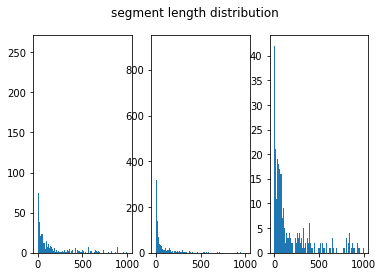

In [48]:
human_intrvl_len = [30*intrvl.size() for intrvl in humans[0].get_intervals()]
car_intrvl_len = [30*intrvl.size() for intrvl in cars[0].get_intervals()]
trans_intrvl_len = [30*intrvl.size() for intrvl in trans[0].get_intervals()]

print(f'mean={np.mean(human_intrvl_len)}, var={np.std(human_intrvl_len)}')
print(f'mean={np.mean(car_intrvl_len)}, var={np.std(car_intrvl_len)}')
print(f'mean={np.mean(trans_intrvl_len)}, var={np.std(trans_intrvl_len)}')

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.suptitle('segment length distribution')
ax1.hist(human_intrvl_len, bins=200,range=(0,1000))
ax2.hist(car_intrvl_len, bins=200,range=(0,1000))
ax3.hist(trans_intrvl_len, bins=200,range=(0,1000))

plt.show()

In [49]:
t = time.time()
human_intersect_car = humans.join(
    cars,
    predicate = and_pred(
        Bounds3D.T(overlaps()),
        Bounds3D.X(overlaps()),
        Bounds3D.Y(overlaps())
    ),
    merge_op = lambda interval1, interval2: Interval(
        interval1['bounds'].intersect_time_span_space(interval2['bounds']),
        payload = {"human": interval1['payload'], "car":interval2['payload']}
    ),
    window = 0.0,
    progress_bar = True
)
t = time.time() - t
print("Time cost: ", t)


100%|██████████| 1/1 [00:19<00:00, 19.20s/it]Time cost:  19.21531891822815



In [50]:
print("Number of segemtns:", len(human_intersect_car[0]))
human_intersect_car[0].get_intervals()[:10]

Number of segemtns: 2634


[<Interval t1:38.6 t2:38.8 x1:0.0 x2:1.0 y1:0.0 y2:1.0 payload:{'human': {'score': 0.93340355, 'class': True}, 'car': {'score': 0.04601707, 'class': True}}>,
 <Interval t1:39.03333333333333 t2:39.06666666666667 x1:0.0 x2:1.0 y1:0.0 y2:1.0 payload:{'human': {'score': 0.93340355, 'class': True}, 'car': {'score': 0.030757142, 'class': True}}>,
 <Interval t1:39.3 t2:39.333333333333336 x1:0.0 x2:1.0 y1:0.0 y2:1.0 payload:{'human': {'score': 0.93340355, 'class': True}, 'car': {'score': 0.053581983, 'class': True}}>,
 <Interval t1:47.5 t2:54.733333333333334 x1:0.0 x2:1.0 y1:0.0 y2:1.0 payload:{'human': {'score': 0.98054343, 'class': True}, 'car': {'score': 0.18748133, 'class': True}}>,
 <Interval t1:58.43333333333333 t2:61.43333333333333 x1:0.0 x2:1.0 y1:0.0 y2:1.0 payload:{'human': {'score': 0.98949707, 'class': True}, 'car': {'score': 0.15591979, 'class': True}}>,
 <Interval t1:63.733333333333334 t2:65.63333333333334 x1:0.0 x2:1.0 y1:0.0 y2:1.0 payload:{'human': {'score': 0.98949707, 'class

mean=138.02429764616258, var=582.6353074262994


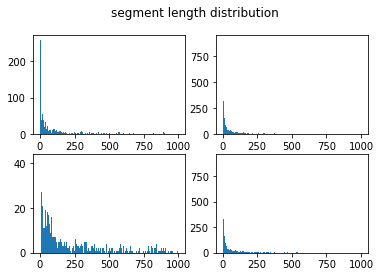

In [52]:
hc_intrvl_len = [30*intrvl.size() for intrvl in human_intersect_car[0].get_intervals()]

print(f'mean={np.mean(hc_intrvl_len)}, var={np.std(hc_intrvl_len)}')

fig, axs = plt.subplots(2, 2)
fig.suptitle('segment length distribution')
axs[0,0].hist(human_intrvl_len, bins=200,range=(0,1000))
axs[0,1].hist(car_intrvl_len, bins=200,range=(0,1000))
axs[1,0].hist(trans_intrvl_len, bins=200,range=(0,1000))
axs[1,1].hist(hc_intrvl_len, bins=200,range=(0,1000))
plt.show()

In [53]:
human_and_car_and_voice = human_intersect_car.join(
    trans,
    predicate = and_pred(
        Bounds3D.T(overlaps()),
        Bounds3D.X(overlaps()),
        Bounds3D.Y(overlaps())
    ),
    merge_op = lambda interval1, interval2: Interval(
        interval1['bounds'].intersect_time_span_space(interval2['bounds']),
        payload = {**interval1['payload'], "transcript":interval2['payload']}
    ),
    window = 0.0,
    progress_bar = True
)


100%|██████████| 1/1 [00:10<00:00, 10.40s/it]


In [54]:
print("Number of segemtns:", len(human_and_car_and_voice[0]))
human_and_car_and_voice[0].get_intervals()[:10]

Number of segemtns: 2765


[<Interval t1:38.6 t2:38.8 x1:0.0 x2:1.0 y1:0.0 y2:1.0 payload:{'human': {'score': 0.93340355, 'class': True}, 'car': {'score': 0.04601707, 'class': True}, 'transcript': {'score': 1.0, 'class': "the one hundred and fifty year old trree taken down the gu k to make way for a ousing development that apparently did not include the t in its plan strangely symbolic moment for a country that's been notcked down and now lot down again showed out in georgia voters taken to the polls today waiting on some long lines to decide the balance of power in all of washington d see the high states battle between senate candidate to accuse each other with some a low los president trump attacking fellow republicans of the state how his high pressure campaign is playing out meanwhile president trump issuing a veil threread to vice president pence calling on pence to step in on that proing electoral college fight nations 's capital on high alert with thousands of trump supporters expected to protest there to

mean=123.41692585894855, var=381.5243644965209


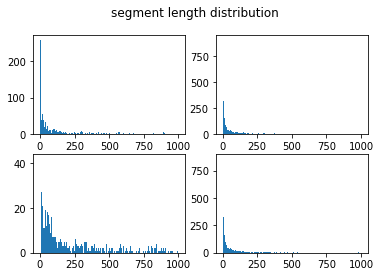

In [55]:
hct_intrvl_len = [30*intrvl.size() for intrvl in human_and_car_and_voice[0].get_intervals()]

print(f'mean={np.mean(hct_intrvl_len)}, var={np.std(hct_intrvl_len)}')

fig, axs = plt.subplots(2, 2)
fig.suptitle('segment length distribution')
axs[0,0].hist(human_intrvl_len, bins=200,range=(0,1000))
axs[0,1].hist(car_intrvl_len, bins=200,range=(0,1000))
axs[1,0].hist(trans_intrvl_len, bins=200,range=(0,1000))
axs[1,1].hist(hct_intrvl_len, bins=200,range=(0,1000))
plt.show()